In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Databehandling
Skogsbränder kräver inte viktiga detaljer för att avgöra om det är en skogsbrand eller inte. Därför kommer bildernas storlek att minskas för att både datan och modellen ska ta upp mindre utrymme. Dessutom kommer det att sätta fart på träningen eftersom alla modeller kommer ha mindre pixlar att kolla igenom.

Bildernas originella storlek är 250x250, deras nya storlek kommer att bli 128x128.

In [7]:
data_dir = 'data'
image_height, image_width = 128, 128

X = []
y = []

for folder in os.listdir('data'):
    label = 1 if folder.split('-')[0] == 'fire' else 0
    source = f'data/{folder}'

    for image_file in os.listdir(f'data/{folder}'):
        destination = f'{source}/{image_file}'
        image = cv2.imread(destination)
        if image is None:
            os.remove(destination)  # remove corrupt images
            continue

        try:
            image = cv2.resize(image, (image_width, image_height))
        except:
            continue

        X.append(image)
        y.append(label)

### Exempel på bilder

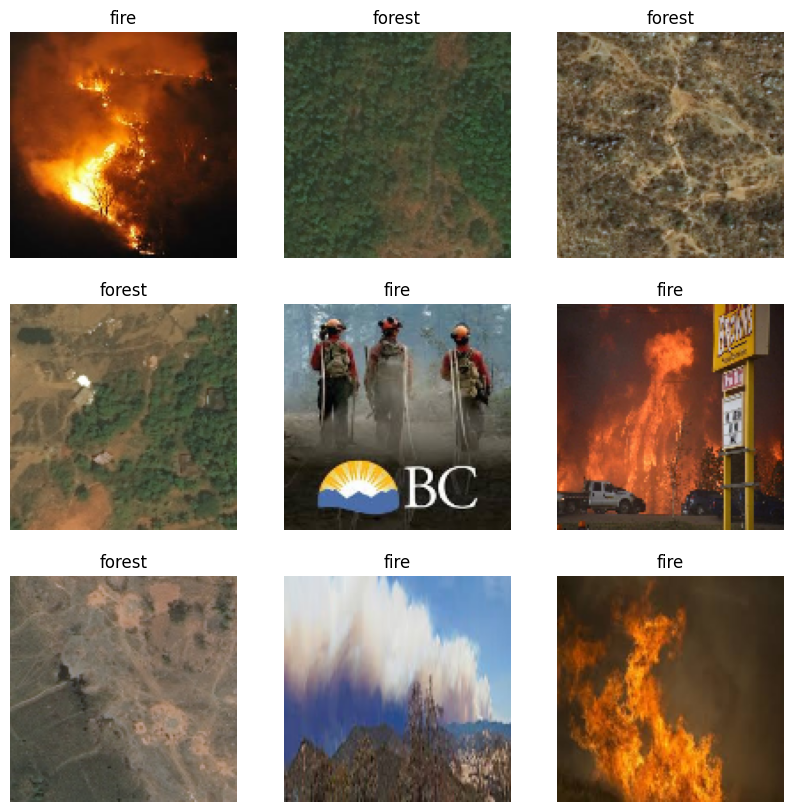

In [9]:
from random import randint

plt.figure(figsize=(10, 10))
for x in range(9):
    ax = plt.subplot(3, 3, x + 1)
    
    i = randint(1, 4000)
    image = cv2.cvtColor(X[i], cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title('fire' if y[i] == 1 else 'forest')
    plt.axis("off")

KNN och SVM kommer att behöva data som är tvådimensionell. Här omvandlas det till lämplig storlek.

In [4]:
X = np.array([image.flatten() for image in X])  # flatten for knn, svm

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

### SVM

In [5]:
svm_model = SVC()
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.9518324607329843

### KNN

In [6]:
knn_model = KNeighborsClassifier(n_neighbors=2)
knn_model.fit(X_train, y_train)

y_pred = knn_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8890052356020942

### CNN
Tensorflow har inbyggda funktioner för att enkelt läsa in data. CNN-modellen kräver fyrdimensionell data och det här är ett enkelt sätt att läsa in och omvandla data från mappar.

In [ ]:
batch_size = 64

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    label_mode='int',
    subset="training",
    seed=123,
    shuffle=True,
    image_size=(image_height, image_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    label_mode='int',
    subset="validation",
    seed=123,
    shuffle=True,
    image_size=(image_height, image_width),
    batch_size=batch_size
)

Skogsbränder är relativt simpla att upptäcka och vi såg tidigare att både KNN och SVM kunde få hög träffsäkerhet. Därför kan vi nöja oss med en väldigt simpel CNN-modell.

Bilder kommer att ha värden mellan 1 - 255 vilket inte är optimalt för en CNN-modell. På grund av det så har modellen ett lager som omvandlar datan till värden mellan 0 - 1.

Modellen kommer att mata ut två värden med ett softmax lager. Det kommer att kunna användas som en sorts sannolikhet för att avgöra hur säker modellen är att den faktiskt ser en skogsbrand eller inte.

In [7]:
cnn_model = keras.models.Sequential([
    layers.Input((image_height, image_width, 3)),
    layers.Rescaling(1./255),

    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2, activation='softmax')
])

cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

epochs=10
history = cnn_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Found 4772 files belonging to 2 classes.
Using 3818 files for training.
Found 4772 files belonging to 2 classes.
Using 954 files for validation.
Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 0.6857 - loss: 0.7161 - val_accuracy: 0.8658 - val_loss: 0.3650
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.9472 - loss: 0.1588 - val_accuracy: 0.9717 - val_loss: 0.0818
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.9693 - loss: 0.0881 - val_accuracy: 0.9665 - val_loss: 0.1129
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.9793 - loss: 0.0686 - val_accuracy: 0.9843 - val_loss: 0.0569
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.9812 - loss: 0.0584 - val_accuracy: 0.9518 - val_loss: 0.1423
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.9748 - loss: 0.0702 - val_accuracy: 0.9748 - val_loss: 0.0703
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - accuracy: 0.9843 - loss: 0.0528 -

### Resultat

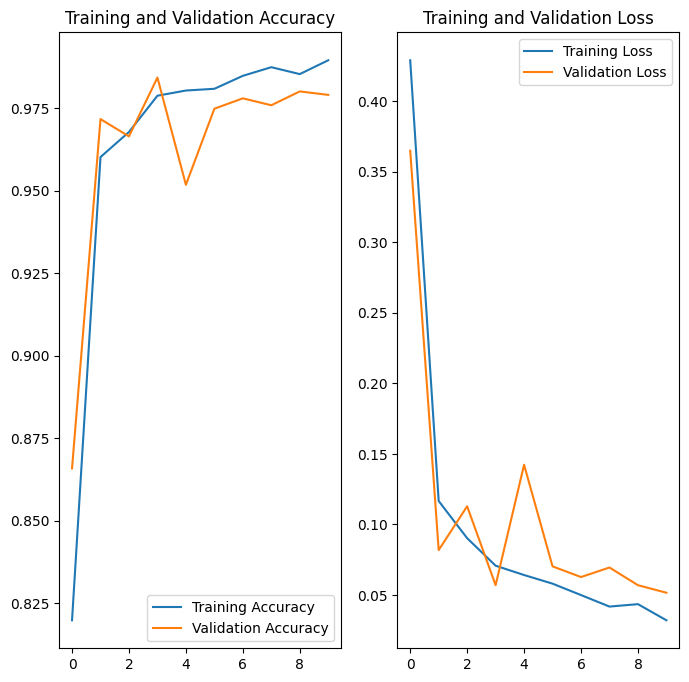

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Slutliga tester

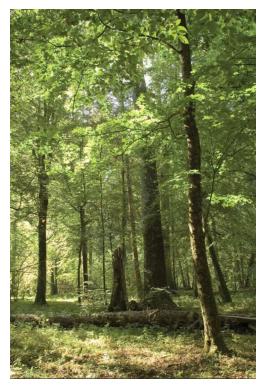

In [9]:
test_image = cv2.imread('forest.jpg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(test_image)

In [10]:
test_image = cv2.cvtColor(test_image, cv2.COLOR_RGB2BGR)
test_image = cv2.resize(test_image, (128, 128))

input_2d = test_image.flatten()
input_4d = np.expand_dims(test_image, axis=0)

In [11]:
svm_result = svm_model.predict([input_2d])[0]

knn_result = knn_model.predict([input_2d])[0]

cnn_answers = ['fire', 'forest']
cnn_result = cnn_model.predict(input_4d)
cnn_result = np.argmax(cnn_result)

print('CNN model prediction:', cnn_answers[cnn_result])
print('KNN model prediction:', knn_result)
print('SVM model prediction:', svm_result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
CNN model prediction: forest
KNN model prediction: forest
SVM model prediction: forest


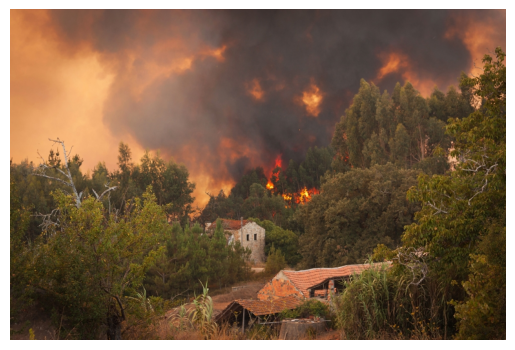

In [12]:
test_image = cv2.imread('fire.jpeg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(test_image)

In [13]:
test_image = cv2.cvtColor(test_image, cv2.COLOR_RGB2BGR)
test_image = cv2.resize(test_image, (128, 128))

input_2d = test_image.flatten()
input_4d = np.expand_dims(test_image, axis=0)

svm_result = svm_model.predict([input_2d])[0]

knn_result = knn_model.predict([input_2d])[0]

cnn_answers = ['fire', 'forest']
cnn_result = cnn_model.predict(input_4d)
cnn_result = np.argmax(cnn_result)

print('CNN model prediction:', cnn_answers[cnn_result])
print('KNN model prediction:', knn_result)
print('SVM model prediction:', svm_result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
CNN model prediction: fire
KNN model prediction: fire
SVM model prediction: fire


## Slutlig modell

På grund av att CNN modellen fick högre accuracy score under träning och för att Tensorflow har en inbyggda funktioner för att spara och ladda modeller så kommer vi att använda CNN modellen.

In [14]:
tf.saved_model.save(cnn_model, 'model')

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


Med hjälp av Intels OpenVINO kan AI-modeller användas inuti applikationer i realtid relativt enkelt. För att kunna använda en Tensorflow modell i OpenVINO så måste den omvandlas till lämpligt format.

In [17]:
convert_command = f'mo --saved_model_dir model --input_shape [1,{image_height},{image_width},3] --output_dir model'

! $convert_command

Check for a new version of Intel(R) Distribution of OpenVINO(TM) toolkit here https://software.intel.com/content/www/us/en/develop/tools/openvino-toolkit/download.html?cid=other&source=prod&campid=ww_2023_bu_IOTG_OpenVINO-2023-0&content=upg_all&medium=organic or on https://github.com/openvinotoolkit/openvino
[ INFO ] The model was converted to IR v11, the latest model format that corresponds to the source DL framework input/output format. While IR v11 is backwards compatible with OpenVINO Inference Engine API v1.0, please use API v2.0 (as of 2022.1) to take advantage of the latest improvements in IR v11.
Find more information about API v2.0 and IR v11 at https://docs.openvino.ai/2023.0/openvino_2_0_transition_guide.html
[ INFO ] IR generated by new TensorFlow Frontend is compatible only with API v2.0. Please make sure to use API v2.0.
Find more information about new TensorFlow Frontend at https://docs.openvino.ai/2023.0/openvino_docs_MO_DG_TensorFlow_Frontend.html
[ SUCCESS ] Generated

Applikationen finns i mappen "app"